# Portfoliobenadering betrouwbaarheidseisen
Faalfrequenties en betrouwbaarheidseisen voor grote aantallen vergelijkbare constructies in relatie tot de NEN 8700.

## Uitgangspunten en definities

### Portfolio kademuren

In [108]:
n_kades = 300  # aantal constructies ('onafhankelijke kademuren')
aandeel_versterking = 0.1  # worden versterkt, dus niet meetellen
n_con = int(round(n_kades * (1 - aandeel_versterking)))  # aantal te beschouwen constructies
UC_range = np.array([0.7, 1.0])
ref_period = 15
p_cond_damage = 0.1

### Grenstoestandsfunctie
$ Z = p * m_R * R - a_Q * m_Q * Q - (1 - a_Q) * G$

met 
- $p$ = design parameter (verhouding sterkte/belasting)
- $m_R$ = modelonzekerheid sterkte (tijdsonafhankelijk, volledig gecorreleerd in de tijd; volledige correlatie tussen constructies)
- $R$ = sterkte (tijdsonafhankelijk, volledig gecorreleerd in de tijd; geen correlatie tussen constructies)
- $a_Q$ = aandeel veranderlijke belasting ($=mu_Q/mu_G$)
- $m_Q$ = modelonzekerheid veranderlijke belasting (tijdsonafhankelijk, volledig gecorreleerd in de tijd; volledige correlatie tussen constructies)
- $Q$ = veranderlijke belasting (tijdsafhankelijk, ongecorreleerd tussen jaren; geen correlatie tussen constructies)
- $G$ = permanente belasting (eigen gewicht; volledig gecorreleerd in de tijd; geen correlatie tussen constructies)

In [109]:
def LimitStateFunction(p, mR, R, aQ, mQ, Q, G):
    Z = p * mR * R - aQ *  mQ *Q - (1-aQ) * G
    return Z

### Unity check
$ UC = p * R_{kar} / \gamma_R - a_Q * Q_{kar} * \gamma_Q - (1 - a_Q) * G_{kar}$

met 
- $p$ = design parameter (verhouding sterkte/belasting)
- $R_{kar}$ = karakteristieke waarde sterkte (5%-kwantiel $R$)
- $a_Q$ = aandeel veranderlijke belasting
- $Q_{kar}$ = karakteristieke waarde veranderlijke belasting (98%-kwantiel $Q$)
- $G_{kar}$ = karakteristieke waarde permanente belasting (50%-kwantiel $G$)

In [110]:
from scipy.stats import norm

def UnityCheck(p, V_R, gamma_R, V_Q, gamma_Q):
    R_kar = 1 - 1.645 * V_R
    Q_kar = norm.ppf(0.98, loc = 1, scale = V_Q)
    G_kar = 1
    UC = (aQ * Q_kar * gamma_Q + (1-aQ) * G_kar) / (p * R_kar / gamma_R)
    return UC

Bepaal p for gegeven UC:

In [111]:
def Get_P_for_UC(UC, V_R, gamma_R, V_Q, gamma_Q):
    R_kar = 1 - 1.645 * V_R
    Q_kar = norm.ppf(0.98, loc = 1, scale = V_Q)
    G_kar = 1
    p =  (aQ * Q_kar * gamma_Q + (1-aQ) * G_kar) / (UC * R_kar / gamma_R)
    return p

### Variatiecoefficienten
voor genormaliseerde stochasten (c.q. gemiddelden gelijk aan 1)

In [112]:
V_mR = 0.12
V_R = 0.15
V_mQ = 0.1
V_Q = 0.15
V_G = 0.05

### Partiele factoren

In [113]:
gamma_R = 1.1
gamma_Q = 1.05

## Analyse
### Keuze aQ en p, en bereken unity check (UC)

In [114]:
aQ = 0.5  # verhouding veranderlijke versus permanente belasting
p_range = Get_P_for_UC(UC_range, V_R, gamma_R, V_Q, gamma_Q)

# p = 1.50  # design parameter ('verhouding sterkte versus belasting gemiddeld')
#UC = UnityCheck(p, V_R, gamma_R, V_Q, gamma_Q)
#print('UC = ', UC)

### Faalkansanalyse (MCS met numpy)
#### Realisaties stochasten en bepalen faalkans en schadefrequentie

In [115]:
import numpy as np

n_mcs = int(5e+4)  # aantal realisaties in Monte Carlo analyse

np.random.seed(None)
UC = np.random.uniform(UC_range.min(), UC_range.max(), n_con)
p = Get_P_for_UC(UC, V_R, gamma_R, V_Q, gamma_Q)
mR = np.random.randn(n_mcs) * V_mR + 1.0
R = np.random.randn(n_mcs, n_con) * V_R + 1.0
mQ = np.random.randn(n_mcs) * V_mQ + 1.0
Q = np.random.randn(n_mcs, n_con) * V_mQ + 1.0
G = np.random.randn(n_mcs, n_con) * V_G + 1.0

for con in range(0, n_con):
    Zi = LimitStateFunction(p[con], mR, R[:,con], aQ, mQ, Q[:,con], G[:,con])
    if con == 0:
        Z = Zi
    else:
        # Z = np.append(Z, Zi).reshape((n_mcs, con+1)) # reshape werkt niet als bedoeld...
        Z = np.column_stack((Z, Zi))

Fail = Z<0
Damage = p_cond_damage * Fail
Pf_con = Fail.sum(axis=0)/n_mcs
beta_con = norm.ppf(1-Pf_con)
Pf_con_gem = np.average(Pf_con)
beta_con_gem = norm.ppf(1-Pf_con_gem)

Pf_port_onafh = 1 - np.prod((1-Pf_con))

n_fail_port = Fail.sum(axis=1)
Pf_port = sum(n_fail_port>0) / n_mcs 
EF_port = n_fail_port.sum(axis=0)/n_mcs

PD_port = Pf_port * p_cond_damage
ED_port = EF_port * p_cond_damage

print('Aantal "onafhankelijke" voldoende constructies:', n_con )
print('Range UC-waarden bij voldoende (uniforme verdeling):', UC_range)
print('Pf (grenstoestand) per constructie (gemiddeld):', '{:.1e}'.format(Pf_con_gem))
print('Beta per constructie (gemiddeld):', round(beta_con_gem,2))
print('Faalkans portfolio (per 15 jaar) "onafhankelijk":', round(Pf_port_onafh,2))
print('Faalkans portfolio (per 15 jaar) met correlatie:', round(Pf_port,2))
print('Verwachtingswaarde falen (per 15 jaar):', round(EF_port,2))
print('Schadekans portfolio (per 15 jaar)', round(PD_port,2))
print('Verwachtingswaarde schades (per 15 jaar):', round(ED_port,2))
print('Verwachtingswaarde schades (per jaar):', round(ED_port/ref_period, 3), '(benadering)') # benadering: F/n jaar

Aantal "onafhankelijke" voldoende constructies: 270
Range UC-waarden bij voldoende (uniforme verdeling): [0.7 1. ]
Pf (grenstoestand) per constructie (gemiddeld): 2.8e-03
Beta per constructie (gemiddeld): 2.77
Faalkans portfolio (per 15 jaar) "onafhankelijk": 0.53
Faalkans portfolio (per 15 jaar) met correlatie: 0.29
Verwachtingswaarde falen (per 15 jaar): 0.76
Schadekans portfolio (per 15 jaar) 0.03
Verwachtingswaarde schades (per 15 jaar): 0.08
Verwachtingswaarde schades (per jaar): 0.005 (benadering)


### Plot some results

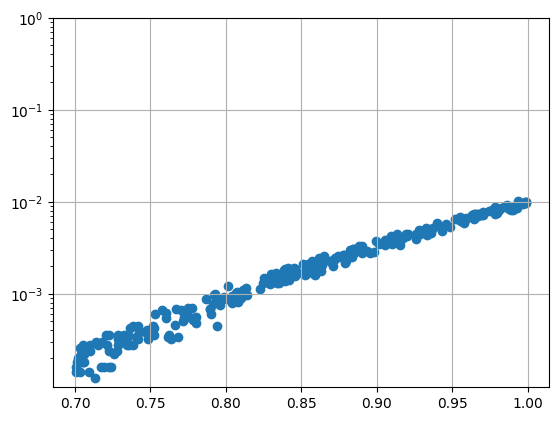

In [117]:
import matplotlib.pyplot as plt

def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=[1])
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins)
  plt.xscale('log')
  
fig, ax = plt.subplots()
# plot_loghist(Pf_con, 10)
# ax.set_xticks([1e-4, 1e-3, 1e-2, 0.1, 1])
plt.scatter(UC,Pf_con)
plt.yscale('log')
ax.set_yticks([1e-3, 1e-2, 0.1, 1])
plt.grid()
plt.show()


## Next steps
- afstemmen uitgangspunten met PBK
- illustreren dat UC=1 -> beta iets hoger dan target 1.8 (~2.3)
- betere verdeling UC waarden bij oordeel voldoende 
- inbouwen 'hidden safety' (als conditionele kans op schade, gegeven overschrijden grenstoestand)
- ... (zie PvA offerte)